In [2]:
import pandas as pd
import numpy as np
import time

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
vic_data = pd.read_csv('victoria.csv', parse_dates=[0])

In [4]:
BATTERY_POWER = 300
BATTERY_CAPACITY = 580
EFFICIENCY = 0.9
MARGINAL_LOSS_FACTOR = 0.991
FIXED_OPERATIONS_MAINTENANCE = 8.1
TRADING_PRICE = 'Regions VIC Trading Price ($/MWh)'

CHARGING_LOOKAHEAD = 10
CHARGING_PERCENTILE = 0.25

DISCHARGING_LOOKAHEAD = 10
DISCHARGING_PERCENTILE = 0.75

## Algorithm 3 (from Chieh)

In [5]:
vic_price = vic_data[['Time (UTC+10)',TRADING_PRICE]]

vic_price['charging_or_not'] = 0
vic_price['discharging_or_not'] = 0

vic_price['raw_power'] = 0

vic_price['market_dispatch'] = 0

vic_price['opening_capacity'] = 0
vic_price['closing_capacity'] = 0

vic_price['revenue'] = 0

In [6]:
# percentile.exc from excel != np.percentile (np.percentile == percentile.inc from excel)
# code taken from https://stackoverflow.com/questions/38596100/python-equivalent-of-excels-percentile-exc

def quantile_exc(ser, q):
    ser_sorted = ser.sort_values()
    rank = q * (len(ser) + 1) - 1
    assert rank > 0, 'quantile is too small'
    rank_l = int(rank)
    return ser_sorted.iat[rank_l] + (ser_sorted.iat[rank_l + 1] - ser_sorted.iat[rank_l]) * (rank - rank_l)

In [7]:
start_time_charge = time.time()

for i in list(vic_price.index)[1:]:

    if((i+CHARGING_LOOKAHEAD+1) < len(vic_price)):
        
        thelist = vic_price.iloc[i+1:i+CHARGING_LOOKAHEAD+1][TRADING_PRICE]
        ser = pd.Series(thelist)

        
        if(quantile_exc(ser,0.25) < vic_price.at[i,TRADING_PRICE]):
            vic_price.at[i,'charging_or_not'] = 0
        else:
            vic_price.at[i,'charging_or_not'] = 1
            
            
        if(quantile_exc(ser,0.75) > vic_price.at[i,TRADING_PRICE]):
            vic_price.at[i,'discharging_or_not'] = 0
        else:
            vic_price.at[i,'discharging_or_not'] = 1
            
            
end_time_charge = time.time()
behavior_time = end_time_charge - start_time_charge

In [8]:
start_time = time.time()


for i in list(vic_price.index)[1:]:
    
    
    # update opening capacity
    if(i != 0):
        vic_price.at[i, 'opening_capacity'] = vic_price.at[i-1, 'closing_capacity']
    
    
    # finding raw_power -- this uses the modified function Akira gave us in the last announcement
    if(vic_price.at[i,'charging_or_not'] == 1):
        vic_price.at[i,'raw_power'] = -1*min(BATTERY_POWER, 
                                           (BATTERY_CAPACITY-vic_price.at[i,'opening_capacity'])/EFFICIENCY*2)

    if(vic_price.at[i,'discharging_or_not'] == 1):
        vic_price.at[i,'raw_power'] = min(BATTERY_POWER, vic_price.at[i,'opening_capacity']/EFFICIENCY*2)
        
        
    # finding market_dispatch 
    if(vic_price.at[i,'raw_power'] < 0):
        vic_price.at[i,'market_dispatch'] = vic_price.at[i,'raw_power']/2
        
    else:
        # EFFICIENCY is already in decimal (0.9) so no need to divide by 100
        vic_price.at[i,'market_dispatch'] = vic_price.at[i,'raw_power']/2 * EFFICIENCY 
        
        
    # finidng closing_capacity   
    if(vic_price.at[i,'market_dispatch'] < 0):
        thecondition = vic_price.at[i,'opening_capacity'] - (vic_price.at[i,'market_dispatch'] * EFFICIENCY)
    else:
        thecondition = vic_price.at[i,'opening_capacity'] - (vic_price.at[i,'market_dispatch'] * (100/(EFFICIENCY*100)))
    
    vic_price.at[i,'closing_capacity'] = round(max(0, min(thecondition, BATTERY_CAPACITY)),0)
      
        
        
    #finding revenue        
    if(vic_price.at[i,'market_dispatch'] < 0):
        vic_price.at[i,'revenue'] = round(vic_price.at[i,'market_dispatch'] * vic_price.at[i,TRADING_PRICE] * (1/MARGINAL_LOSS_FACTOR),0)
    else:
        vic_price.at[i,'revenue'] = round(vic_price.at[i,'market_dispatch'] * vic_price.at[i,TRADING_PRICE] * MARGINAL_LOSS_FACTOR,0)


end_time = time.time()
loop_time = end_time - start_time

In [9]:
thetime = vic_price.loc[(vic_price['Time (UTC+10)'] >= '2020-07-17') & (vic_price['Time (UTC+10)'] < '2020-07-18')]

In [10]:
thetimereq = thetime[['Time (UTC+10)','Regions VIC Trading Price ($/MWh)','raw_power','opening_capacity']]
thetimereq = thetimereq.set_index('Time (UTC+10)')
thetimereq.head()

,Regions VIC Trading Price ($/MWh),raw_power,opening_capacity
Time (UTC+10),,,
2020-07-17 00:00:00,79.09,0,0
2020-07-17 00:30:00,75.51,0,0
2020-07-17 01:00:00,73.98,0,0
2020-07-17 01:30:00,75.57,0,0
2020-07-17 02:00:00,71.94,0,0


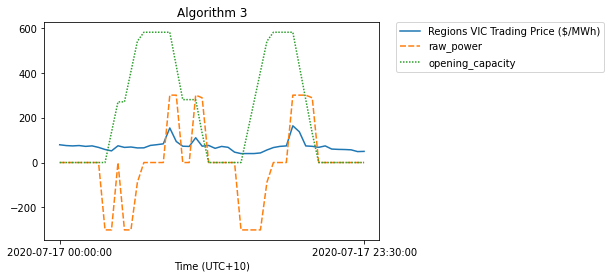

In [11]:
sns.lineplot(data=thetimereq)

plt.xticks([thetime['Time (UTC+10)'].min(), thetime['Time (UTC+10)'].max()])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Algorithm 3')
plt.savefig("algorithm3.png", bbox_inches = 'tight')

plt.show()

## Algorithm 3 Revised (from Chieh)

In [12]:
CHARGING_LOOKAHEAD = 5

In [ ]:
start_time_charge = time.time()

for i in list(vic_price.index)[1:]:

    if((i+CHARGING_LOOKAHEAD+1) < len(vic_price)):
        
        thelist = vic_price.iloc[i+1:i+CHARGING_LOOKAHEAD+1][TRADING_PRICE]
        ser = pd.Series(thelist)

        
        if(quantile_exc(ser,0.25) < vic_price.at[i,TRADING_PRICE]):
            vic_price.at[i,'charging_or_not'] = 0
        else:
            vic_price.at[i,'charging_or_not'] = 1
            
            
        if(quantile_exc(ser,0.75) > vic_price.at[i,TRADING_PRICE]):
            vic_price.at[i,'discharging_or_not'] = 0
        else:
            vic_price.at[i,'discharging_or_not'] = 1
            
            
end_time_charge = time.time()
behavior_time = end_time_charge - start_time_charge

In [ ]:
start_time = time.time()

for i in list(vic_price.index)[1:]:
    
    
    # update opening capacity
    if(i != 0):
        vic_price.at[i, 'opening_capacity'] = vic_price.at[i-1, 'closing_capacity']
    
    
    
    # finding raw_power -- this uses the modified function Akira gave us in the last announcement
    if(vic_price.at[i,'charging_or_not'] == 1):
        vic_price.at[i,'raw_power'] = -1*min(BATTERY_POWER, 
                                           (BATTERY_CAPACITY-vic_price.at[i,'opening_capacity'])/EFFICIENCY*2)

    if(vic_price.at[i,'discharging_or_not'] == 1):
        vic_price.at[i,'raw_power'] = min(BATTERY_POWER, vic_price.at[i,'opening_capacity']/EFFICIENCY*2)
        
        
        
    # finding market_dispatch 
    if(vic_price.at[i,'raw_power'] < 0):
        vic_price.at[i,'market_dispatch'] = vic_price.at[i,'raw_power']/2
        
    else:
        # EFFICIENCY is already in decimal (0.9) so no need to divide by 100
        vic_price.at[i,'market_dispatch'] = vic_price.at[i,'raw_power']/2 * EFFICIENCY 
        
        
        
    # finidng closing_capacity   
    if(vic_price.at[i,'market_dispatch'] < 0):
        thecondition = vic_price.at[i,'opening_capacity'] - (vic_price.at[i,'market_dispatch'] * EFFICIENCY)
    else:
        thecondition = vic_price.at[i,'opening_capacity'] - (vic_price.at[i,'market_dispatch'] * (100/(EFFICIENCY*100)))
    
    vic_price.at[i,'closing_capacity'] = round(max(0, min(thecondition, BATTERY_CAPACITY)),0)
      
        
        
    #finding revenue        
    if(vic_price.at[i,'market_dispatch'] < 0):
        vic_price.at[i,'revenue'] = round(vic_price.at[i,'market_dispatch'] * vic_price.at[i,TRADING_PRICE] * (1/MARGINAL_LOSS_FACTOR),0)
    else:
        vic_price.at[i,'revenue'] = round(vic_price.at[i,'market_dispatch'] * vic_price.at[i,TRADING_PRICE] * MARGINAL_LOSS_FACTOR,0)


end_time = time.time()
loop_time = end_time - start_time

In [ ]:
thetime = vic_price.loc[(vic_price['Time (UTC+10)'] >= '2020-07-17') & (vic_price['Time (UTC+10)'] < '2020-07-18')]

In [ ]:
thetime.head()

In [ ]:
thetimereq = thetime[['Time (UTC+10)','Regions VIC Trading Price ($/MWh)','raw_power','opening_capacity']]
thetimereq = thetimereq.set_index('Time (UTC+10)')
thetimereq.head()

In [ ]:
sns.lineplot(data=thetimereq)

plt.xticks([thetime['Time (UTC+10)'].min(), thetime['Time (UTC+10)'].max()])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Algorithm 3 (Revised)')
plt.savefig("algorithm3_revised.png", bbox_inches = 'tight')

plt.show()

## Algorithm 2 (from Kennedy)

In [ ]:
import pandas as pd
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import time
plt.rc('font', size=12)

# Filter out deprecated warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_excel('../../data/market_data.xlsx')
data1 = data

In [ ]:
TIME = 'Time (UTC+10)'
PRICE = 'Regions VIC Trading Price ($/MWh)'
GENERATION = 'Regions VIC Trading Total Intermittent Generation (MW)'
DEMAND = 'Regions VIC Operational Demand (MW)'

POWER = 300
CAPACITY = 580
CHARGE_EFF = 90
DISCHARGE_EFF = 90
MLF = 0.991
FIXED_OP = 8.1
VAR_OP = 0

In [ ]:
vic = data[['Time (UTC+10)', 'Regions VIC Trading Price ($/MWh)', 
                 'Regions VIC Trading Total Intermittent Generation (MW)', 
                 'Regions VIC Operational Demand (MW)']]

# Since the first date is at 00:00:00, the first period should be 48
period = [48]
x = 1
while x < len(vic):
    for i in range(48):
        period.append(i+1)
        x += 1

vic.insert(1, 'Period', period)

In [ ]:
def first_cycle(spot_price):
    """ Returns first indexes of the first periods for the first cycles """
    
    max_price = 0
    min_price = 999999

    for i in range(48-6):
        """ Finds which 6 periods have the most sum and least sum 
            by going through 1 to 6, 2 to 7 and so on """

        curr = spot_price.iloc[i:i+6 ,0].sum()

        if curr < min_price:
            min_price = curr
            min_i = i  # Stores the first index of the max period

        if curr > max_price:

            max_price = curr
            max_i = i  # Stores the first index of the min period
            
    min_, max_ = store_index(min_i, max_i)
                
    return min_, max_

In [ ]:
def sec_cycle(spot_price, min_index, max_index):
    """ Returns first indexes of the first periods for the second cycles """
    
    remaining = list(spot_price.index)
    sec_min_price = 999999
    sec_max_price = 0
    to_remove = min_index + max_index
    
    # remove all periods after max
    remaining = remaining[:remaining.index(to_remove[-1])+1]
    
    for index in to_remove:
        remaining.remove(index)

    for i in range(len(remaining) - 6):

        # make sure the next six indexes are increment of 1
        if remaining[i] == (remaining[i+5] - 5):

            curr_sum = spot_price.iloc[remaining[i]:remaining[i]+6 ,0].sum()

            if curr_sum < sec_min_price:
                sec_min_price = curr_sum
                sec_min_i = remaining[i]  # Stores the first index of the second max period

            if curr_sum > sec_max_price:

                sec_max_price = curr_sum
                sec_max_i = remaining[i]  # Stores the first index of the second min period
                
    min_, max_ = store_index(sec_min_i, sec_max_i)
    
    min_index += min_
    max_index += max_
                
    return min_index, max_index

In [ ]:
def store_index(index1, index2):
    """ Store the rest of the max and min price indexes """
    list1 = []
    list2 = []
    for i in range(6):
        list1.append(index1 + i)
        list2.append(index2 + i)
        
    return list1, list2

In [ ]:
def algorithm2(ori_df):
    """ Finds optimal charge and discharge period from the mean """
    
    spot_price = ori_df.groupby(['Period'])[[PRICE]].mean()
    
    # First cycle
    min_index, max_index = first_cycle(spot_price)

    # Second cycle
    min_index, max_index = sec_cycle(spot_price, min_index, max_index)

    # the charge and discharge period are fixed in Algorithm 2, +1 to get their periods
    charge_period = list(np.asarray(min_index) + 1)
    discharge_period = list(np.asarray(max_index) + 1)
    
    return charge_period, discharge_period, 

In [ ]:
def create_df(ori_df):
    """ Returns a proper dataframe with columns needed """
    
    raw_power = np.zeros(len(ori_df))
    dispatch = np.zeros(len(ori_df))
    revenue = np.zeros(len(ori_df))
    opening = np.zeros(len(ori_df))
    closing = np.zeros(len(ori_df))

    df = ori_df[[TIME, 'Period', PRICE]]
    df['raw_power'] = raw_power
    df['dispatch'] = dispatch
    df['revenue'] = revenue
    df['opening'] = opening
    df['closing'] = closing
    
    df = df.drop([0], axis=0)
    df['revenue'] = np.nan
    
    return df

In [ ]:
def find_all(ori_df):
    """ Returns a completed dataframe """
    
    start = time.time()
    
    charge_period, discharge_period = algorithm2(ori_df)
    
    df = create_df(ori_df)
    
    for i in list(df.index):

        period = df.at[i, "Period"]
        price = df.at[i, PRICE]

        """ Find Opening Cap """
        if i != 1:
            df.at[i,"opening"] = df.at[i-1,"closing"]

        opening_cap = math.ceil(df.at[i, "opening"])




        """ Find raw_power """
        if period in charge_period:
            df.at[i, "raw_power"] = -math.floor(min(POWER,(CAPACITY-opening_cap)/(CHARGE_EFF/100)*2))

        elif period in discharge_period:
            df.at[i, "raw_power"] = math.floor(min(POWER,opening_cap/(DISCHARGE_EFF/100)*2))

        rawPower = df.at[i, "raw_power"]




        """ Find dispatch """
        if rawPower < 0:
            eff = 1

        else:
            eff = DISCHARGE_EFF / 100

        df.at[i,"dispatch"] = math.ceil(rawPower / 2 * eff)
        dispatch = df.at[i, "dispatch"]



        """ Find Closing Cap """
        if dispatch < 0:
            eff = CHARGE_EFF / 100

        else:
            eff = 100 / DISCHARGE_EFF

        df.at[i,"closing"] = math.ceil(max(0, min((opening_cap - (dispatch * eff)), CAPACITY)))



        """ Find revenue """
        if dispatch < 0:
            factor = 1/MLF

        else:
            factor = MLF

        df.at[i,"revenue"] = math.ceil(price * dispatch * factor)
        
    end = time.time()
    return df

In [ ]:
deliverable3 = vic[(vic[TIME] >= "2020-07-17") & (vic[TIME] < "2020-07-18")]
deliverable3 = deliverable3.reset_index(drop=True)
del3 = find_all(deliverable3)

In [ ]:
thetimereq = del3[['Time (UTC+10)','Regions VIC Trading Price ($/MWh)','raw_power','opening']]
thetimereq = thetimereq.set_index('Time (UTC+10)')
thetimereq.head()

In [ ]:
sns.lineplot(data = thetimereq)

plt.xticks([thetime['Time (UTC+10)'].min(), thetime['Time (UTC+10)'].max()])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Algorithm 2')
plt.savefig("algorithm2.png", bbox_inches = 'tight')

plt.show()